# **Disaster Tweet Classifier**

## **Imports**

In [93]:
import string
import pandas as pd
import numpy as np
import nltk
import heapq
import re
from wordcloud import WordCloud
import seaborn as sns
import csv
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk.stem import PorterStemmer
from nltk import FreqDist 
from nltk.stem.porter import *
nltk.download('stopwords')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize 
from collections import defaultdict

from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go

from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB, CategoricalNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import preprocessing


!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

!pip install pyspellchecker
from spellchecker import SpellChecker

stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Downloading dataset from Drive**

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':'1HV2l5C-MJx3HqReEjkeW2hFPqiOoRcvg'}) 
downloaded.GetContentFile('train.csv')  
train_data_csv = pd.read_csv('train.csv')

train_df = pd.DataFrame(train_data_csv)

## **Exploratory Data Analysis (EDA) of tweets**

###**The distrubition of the two classes 0 and 1**

Percentage of non disaster tweets: 57.0 %

Percentage of disaster tweets: 43.0 %



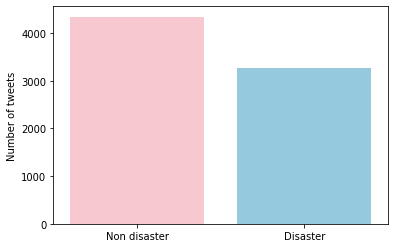

In [0]:
x=train_df.target.value_counts()

fig, ax = plt.subplots()
sns.barplot(x.index,x, palette=['pink', 'skyblue'])
ax.set_ylabel('Number of tweets')
ax.set_xticklabels(["Non disaster",'Disaster'])

print('Percentage of non disaster tweets:',round(sum(train_df['target']==0)/len(train_df)*100,1),'%')
print('\nPercentage of disaster tweets:',round(sum(train_df['target']==1)/len(train_df),2)*100,'%\n')

Conclusion: There is more non-disaster tweets than disaster tweets. 

###**Analyzing the words in the tweets**

####**Number of characters in tweets**

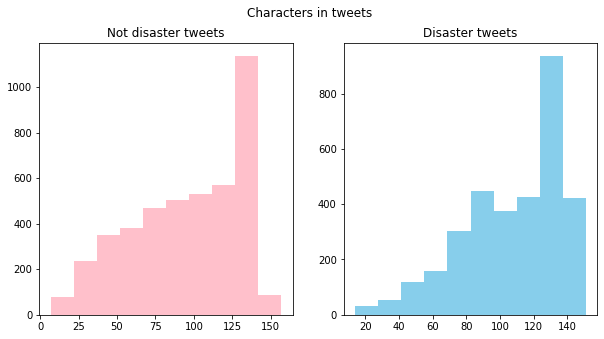

In [0]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

tweet_len=train_df[train_df['target']==0]['text'].str.len()
ax1.hist(tweet_len,color='pink')
ax1.set_title('Not disaster tweets')
tweet_len=train_df[train_df['target']==1]['text'].str.len()
ax2.hist(tweet_len,color='skyblue')
ax2.set_title('Disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

Conclusion: The distribution is almost the same, but there are more short non disaster tweets. But nothing really intresting can be found here.  

####**Number of words in tweets**


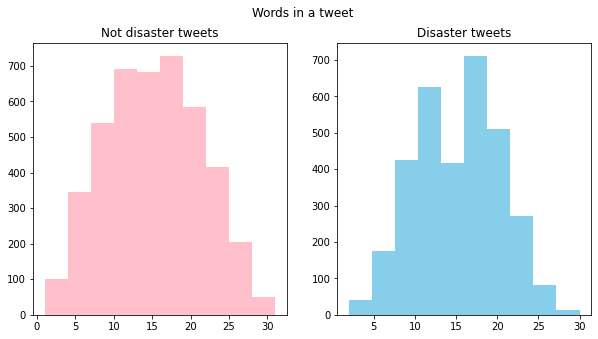

In [0]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train_df[train_df['target']==0]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='pink')
ax1.set_title('Not disaster tweets')
tweet_len=train_df[train_df['target']==1]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='skyblue')
ax2.set_title('Disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()


Conslusion: Same here, the distribution is very similar to the distribution of the characters. 

####**Average word length in tweets**

Text(0.5, 0.98, 'Average word length in each tweet')

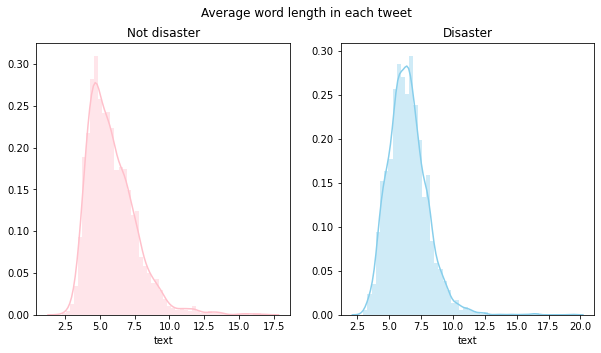

In [0]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train_df[train_df['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='pink')
ax1.set_title('Not disaster')
word=train_df[train_df['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='skyblue')
ax2.set_title('Disaster')
fig.suptitle('Average word length in each tweet')

Conclusion: This follows from the grafs above. We have kind of the same average word length. 

####**Stopwords in tweets**

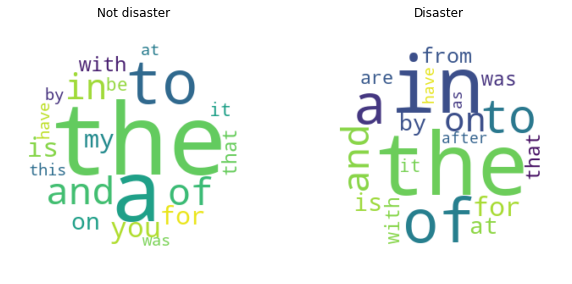

In [0]:
stop_words = set(stopwords.words('english')) 
dic_non_disasters = defaultdict(int)
dic_disasters = defaultdict(int)

for tweet in train_df[train_df['target']==0]['text'].str.split(): 
  for word in tweet:
    if word in stop_words:
      dic_non_disasters[word]+=1

for tweet in train_df[train_df['target']==1]['text'].str.split(): 
  for word in tweet:
    if word in stop_words:
      dic_disasters[word]+=1

top_non_disasters = sorted(dic_non_disasters.items(), key=lambda x:x[1],reverse=True)[:20] 
top_disasters = sorted(dic_disasters.items(), key=lambda x:x[1],reverse=True)[:20] 
top_non_disasters_dict = {}
top_disasters_dict = {}

for i in top_non_disasters:
   top_non_disasters_dict[i[0]] = i[1]

for i in top_disasters:
   top_disasters_dict[i[0]] = i[1]


from wordcloud import WordCloud

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.set_title('Not disaster')
ax2.set_title('Disaster')

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc_1 = WordCloud(background_color="white", mask = mask, max_words=20,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(top_non_disasters_dict)
ax1.imshow(wc_1,interpolation='bilinear')
ax1.axis("off")

wc_2 = WordCloud(background_color="white", mask = mask, max_words=20,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(top_disasters_dict)
ax2.imshow(wc_2,interpolation='bilinear')
ax2.axis("off")

plt.show()

Conclusion: The most common word in both disaster and not disaster is 'the' followed by 'a' in not disaster and 'in' in disaster. The higher frequency of 'in' in the disaster tweets are interesting.   

####**Non stopwords in tweets**

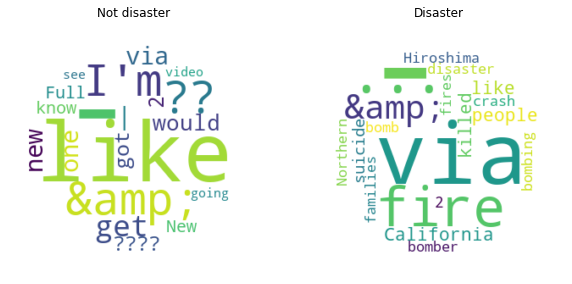

In [0]:
stop_words = set(stopwords.words('english')) 

dic_non_disasters = defaultdict(int)
dic_disasters = defaultdict(int)

for tweet in train_df[train_df['target']==0]['text'].str.split(): 
  for word in tweet:
    if word.lower() not in stop_words and word != "'":
      dic_non_disasters[word]+=1

for tweet in train_df[train_df['target']==1]['text'].str.split(): 
  for word in tweet:
    if word.lower() not in stop_words and word != "'":
      dic_disasters[word]+=1

top_non_disasters = sorted(dic_non_disasters.items(), key=lambda x:x[1],reverse=True)[:20] 
top_disasters = sorted(dic_disasters.items(), key=lambda x:x[1],reverse=True)[:20] 

top_non_disasters_dict = {}
top_disasters_dict = {}

for i in top_non_disasters:
   top_non_disasters_dict[i[0]] = i[1]

for i in top_disasters:
   top_disasters_dict[i[0]] = i[1]


from wordcloud import WordCloud

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.set_title('Not disaster')
ax2.set_title('Disaster')

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc_1 = WordCloud(background_color="white", mask = mask, max_words=20,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(top_non_disasters_dict)
ax1.imshow(wc_1,interpolation='bilinear')
ax1.axis("off")

wc_2 = WordCloud(background_color="white", mask = mask, max_words=20,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(top_disasters_dict)
ax2.imshow(wc_2,interpolation='bilinear')
ax2.axis("off")
plt.show()

Conclusion: When looking at this word cloud we see that we have lots of words that are not nice. Like ..., 2, ????. The conclusion is that we will need datacleaning. 

####**2-gram analysis**

n-gram is a contiguous sequence of n items from a given sample of text or speech

<BarContainer object of 10 artists>

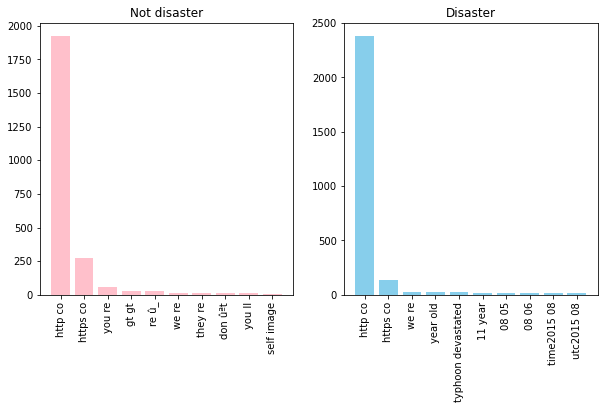

In [0]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

ax1.set_title('Not disaster')
ax2.set_title('Disaster')

not_disaster_tweets=[]
disaster_tweets=[]

for x in train_df[train_df['target']==0]['text'].str.split():
  for i in x:
      not_disaster_tweets.append(i)

for x in train_df[train_df['target']==1]['text'].str.split():
    for i in x:
        disaster_tweets.append(i)

vec = CountVectorizer(ngram_range=(2, 2)).fit(not_disaster_tweets)
bag_of_words = vec.transform(not_disaster_tweets)
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
top_tweet_bigrams = words_freq[:10]

x1,y1=map(list,zip(*top_tweet_bigrams))
ax1.tick_params(labelrotation=90, axis='x')
ax1.bar(x1, y1, color= "pink")


vec = CountVectorizer(ngram_range=(2, 2)).fit(disaster_tweets)
bag_of_words = vec.transform(disaster_tweets)
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
top_tweet_bigrams = words_freq[:10]

x2,y2=map(list,zip(*top_tweet_bigrams))
ax2.tick_params(labelrotation=90, axis='x')
ax2.bar(x2, y2, color= "skyblue")

Conclusion: After looking at these 2-grams we clearly see the need of data cleaning. This will there for be our next step in the project. 

####**Feautures analyzis**

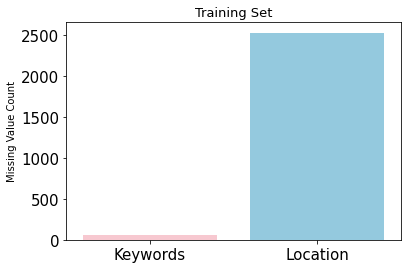

Percentage of tweets missing location: 33.0 %
Percentage of tweets missing keyword: 0.8 %


In [98]:
missing_cols = ['keyword', 'location']

fig, ax  = plt.subplots()

sns.barplot(x=train_df[missing_cols].isnull().sum().index, y=train_df[missing_cols].isnull().sum().values, ax=ax, palette=['pink', 'skyblue'])

ax.set_ylabel('Missing Value Count')
ax.set_xticklabels(["Keywords",'Location'])
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title('Training Set', fontsize=13)


plt.show()

print('Percentage of tweets missing location:',round(sum(train_df['location'].isnull())/len(train_df),2)*100,'%')
print('Percentage of tweets missing keyword:',round(sum(train_df['keyword'].isnull())/len(train_df,),3)*100,'%')

In [0]:
print('Number of unique keywords in the dataset',train_df["keyword"].nunique() )
print('Number of unique locations in the dataset',train_df["location"].nunique() )
train_df.drop(columns=['location'])
plt.show()

Number of unique keywords in the dataset 221
Number of unique locations in the dataset 3341


Conclusion: Due to the high percentage of tweets missing location, we have dicided to drop that feature. Locations are not automatically generated, they are user inputs. That's why `location` is very dirty and there are too many unique values in it. It shouldn't be used as a feature. As we can se we have lots of unique locations, but the keywords are recurring. Therefore we have more proof of why we can drop location.  

## **Data Cleaning**
We will do basic data cleaning, such as spelling correction, removing punctuations, removing html tags and emojis. 
These can harm machine learning algorithms performance so therefore we will carefully get rid of them. 

###**Handling lowercase, and removing URL, html, emojis and punctation**

In [0]:
spell = SpellChecker(distance = 1)
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(tokenized_list):
  text = [word for word in tokenized_list if word not in stopword]
  return text

ps = nltk.PorterStemmer()
def stemming(tokenized_text):
  text = [ps.stem(word) for word in tokenized_text]
  return text

def pre_process(text):
    pre_processed_text = text.lower()  # All lower case
    pre_processed_text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', pre_processed_text)  # Remove URL
    pre_processed_text = re.sub(r'@\w+', '', pre_processed_text)  # Remove mentions
    pre_processed_text = re.sub('[^a-zA-Z\s]', '', pre_processed_text)  # Remove punctuations
    pre_processed_text = re.sub(r'\s+', ' ', pre_processed_text, flags=re.I)  # Replace double spaces
    pre_processed_text = correct_spellings(pre_processed_text)  # Spellcheck
    pre_processed_text = re.split('\W+', pre_processed_text)  # Tokenization
    pre_processed_text = remove_stopwords(pre_processed_text)  # Remove stopwords
    pre_processed_text = stemming(pre_processed_text)  # Apply stemming to reduce words to their root
    
    return pre_processed_text

train_df['cleaned_text'] = train_df['text'].apply(lambda x : pre_process(x))

## **Classifiers**

### **Classifiers using TF-IDF**

####**Creating TF-IDF**

In [0]:
wordfreq = {}
for idx in range(len(train_df['cleaned_text'])):
  for word in train_df['cleaned_text'][idx]:
    if train_df['target'][idx] == 0:
      if word in wordfreq.keys():  # Penalty if the word is used in non-disaster tweets
          wordfreq[word] -= 1
    else:
      if word not in wordfreq.keys():
          wordfreq[word] = 1
      else:
          wordfreq[word] += 1

# This following line takes out the 400 most frequent words and only calculates tf-idf scores for these.
most_freq = heapq.nlargest(400, wordfreq, key=wordfreq.get)

word_idf_values = {}
for key in most_freq:

    doc_containing_word = 0
    for idx in range(len(train_df['cleaned_text'])):
      if key in train_df['cleaned_text'][idx]:
        doc_containing_word += 1
    word_idf_values[key] = np.log(len(train_df['cleaned_text'])/(1 + doc_containing_word))

word_tf_values = {}
for key in most_freq:
    sent_tf_vector = []
    for idx in range(len(train_df['cleaned_text'])):
        doc_freq = 0
        for word in train_df['cleaned_text'][idx]:
            if key == word:
                  doc_freq += 1
        word_tf = doc_freq/len(train_df['cleaned_text'])
        sent_tf_vector.append(word_tf)
    word_tf_values[key] = sent_tf_vector

tfidf_values = []
for key in word_tf_values.keys():
    tfidf_sentences = []
    for tf_sentence in word_tf_values[key]:
        tf_idf_score = tf_sentence * word_idf_values[key]
        tfidf_sentences.append(tf_idf_score)
    tfidf_values.append(tfidf_sentences)

tf_idf_model = np.asarray(tfidf_values)
tf_idf_model = np.transpose(tf_idf_model)

#### **Train Test Split**

In [0]:
X_train_IDF, X_test_IDF, y_train_IDF, y_test_IDF = train_test_split(tf_idf_model, train_df['target'], test_size=0.25, random_state=2000)

#### **Random forest classifier using TF-IDF**

In [0]:
text_classifier = RandomForestClassifier(n_estimators=100, random_state=0)  
text_classifier.fit(X_train_IDF, y_train_IDF)
 
forest_predictions = text_classifier.predict(X_test_IDF)
forest_scores = cross_val_score(text_classifier, tf_idf_model, train_df['target'], cv=5)

#### **Gaussian Naive Bayes classifier using TF-IDF**

In [0]:
gnb = GaussianNB() 
gnb.fit(X_train_IDF, y_train_IDF) 
  
gnb_predictions = gnb.predict(X_test_IDF) 
gnb_scores = cross_val_score(gnb, tf_idf_model, train_df['target'], cv=5)

#### **K-Nearest Neighbors using TF-IDF**

In [0]:
training_accuracy = []
test_accuracy = []

neighbors_settings = range(1, 11)

for n_neighbors in neighbors_settings: 
    clf = KNeighborsClassifier(n_neighbors=n_neighbors) 
    clf.fit(X_train_IDF, y_train_IDF)
    training_accuracy.append(clf.score(X_train_IDF, y_train_IDF))
    test_accuracy.append(clf.score(X_test_IDF, y_test_IDF))

### **Logistic Regression using Vectorizer**


#### **From list to string**

In [0]:
train_df_listToString = []
for i in range(len(train_df['cleaned_text'])):
  train_df_listToString.append(train_df['cleaned_text'][i])

for i in range(len(train_df_listToString)):
  seperator = ' '
  train_df_listToString[i] = seperator.join(train_df_listToString[i])

CV = feature_extraction.text.CountVectorizer()
train_df_vector = CV.fit_transform(train_df_listToString)

#####**Train Test Split**

In [0]:
X_train_vct, X_test_vct, y_train_vct, y_test_vct = train_test_split(
    train_df_vector, train_df["target"], random_state=2000, shuffle=False, test_size=0.25)
classifier_lr = LogisticRegression(max_iter = 200)
classifier_lr.fit(X_train_vct, y_train_vct)
y_pred_lr = classifier_lr.predict(X_test_vct)

print('Logistic Regression Model Accuracy Score for Test Data set is {}'.format(classifier_lr.score(X_test_vct, y_test_vct)))

Logistic Regression Model Accuracy Score for Test Data set is 0.7494747899159664


####**Logistic regression using cross validation**

In [0]:
clf = LogisticRegression(max_iter = 200)
LR_scores = cross_val_score(clf, train_df_vector, train_df.target, cv=4)
print("Cross-validation scores: {}".format(LR_scores))
print("Average cross-validation score: {:.2f}".format(LR_scores.mean()))

Cross-validation scores: [0.71218487 0.68943773 0.67577509 0.74513925]
Average cross-validation score: 0.71


### **Naive Bayes on Meta features**

#### **Creating Meta features** 

Creating meta features on the text features that can be intresting to look at. 

In [0]:
# word_count

train_df_NB = train_df

train_df_NB['word_count'] = train_df_NB['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train_df_NB['unique_word_count'] = train_df_NB['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train_df_NB['stop_word_count'] = train_df_NB['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

# url_count
train_df_NB['url_count'] = train_df_NB['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train_df_NB['mean_word_length'] = train_df_NB['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train_df_NB['char_count'] = train_df_NB['text'].apply(lambda x: len(str(x)))

# punctuation_count
train_df_NB['punctuation_count'] = train_df_NB['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
train_df_NB['hashtag_count'] = train_df_NB['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
train_df_NB['mention_count'] = train_df_NB['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

#### **Naive Bayes on Meta Features using train test split**

In [0]:
# Dropping all rows where keyword is NaN. 
bool_series_keyword = pd.isnull(train_df_NB['keyword']) 
train_df_NB=train_df_NB.drop(train_df_NB[bool_series_keyword].index,axis=0)
train_df_NB=train_df_NB.reset_index(drop=True)

columns_categorical = ['keyword']
columns_numerical = ['word_count','unique_word_count','stop_word_count','url_count',
                        'mean_word_length', 'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']

# we need to first encode the categorical columns
data_train_encoded = pd.DataFrame()

for col in columns_categorical:
  # LabelEncoder transform labels to Array 
  LE = preprocessing.LabelEncoder()
  # fit_transform fit label encoder and return encoded label 
  dt = LE.fit_transform(train_df_NB[col])
  data_train_encoded[col] = dt

# combine with the numerical columns
for col in columns_numerical:
  data_train_encoded[col] = train_df_NB[col]

# add in the encoded class column

data_train_encoded['target'] = train_df_NB['target']

X_train_NB, X_test_NB, y_train_NB, y_test_NB = train_test_split(
    data_train_encoded, train_df_NB['target'], random_state=2000, test_size=0.25)

NaiveBayesModel = GaussianNB()
NaiveBayesModel.fit(pd.DataFrame(X_train_NB, columns=columns_numerical),y_train_NB)
log_p_num = NaiveBayesModel.predict_log_proba(pd.DataFrame(X_test_NB, columns=columns_numerical))


NaiveBayesModel = CategoricalNB()
NaiveBayesModel.fit(pd.DataFrame(X_train_NB, columns=columns_categorical), y_train_NB)
log_p_cat = NaiveBayesModel.predict_log_proba(pd.DataFrame(X_test_NB, columns=columns_categorical))


print("\nThe performance of our Naive Bayes classifier for numerical class is:")
y_pred_class_num = np.argmax(log_p_num, axis=1)
y_pred_sum_num = np.sum(y_pred_class_num==y_test_NB)/len(y_test_NB)
print(np.round(y_pred_sum_num*100, 2), "%")


print("\nThe performance of our Naive Bayes classifier for categorical class is:")
y_pred_class_cat = np.argmax(log_p_cat, axis=1)
y_pred_sum_cat = np.sum(y_pred_class_cat==y_test_NB)/len(y_test_NB)
print(np.round(y_pred_sum_cat*100, 2), "%")

log_p_NB = log_p_num + log_p_cat
y_pred_NB = np.argmax(log_p_NB, axis=1)

y_pred_sum_NB = np.sum(y_pred_NB==y_test_NB)/len(y_test_NB)

print("\nThe performance of our Naive Bayes classifier for both classes are:")
print(np.round(y_pred_sum_NB*100, 2), "%")



The performance of our Naive Bayes classifier for numerical class is:
65.2 %

The performance of our Naive Bayes classifier for categorical class is:
71.93 %

The performance of our Naive Bayes classifier for both classes are:
73.25 %


####**Feature selection on features**

In [0]:
D = 5
est = SelectKBest(chi2, k=D)
X_new = est.fit_transform(data_train_encoded.drop('target', axis=1), data_train_encoded['target'])
sup = est.get_support()
featurenames = data_train_encoded.columns
print('Features selected are:')
best_features = []
for i in np.where(sup)[0]:
  print(featurenames[i])
  best_features.append(featurenames[i])

Features selected are:
keyword
stop_word_count
url_count
char_count
punctuation_count


#### **Naive Bayes on selected features using train test split**

In [0]:
NaiveBayesModel = GaussianNB()
NaiveBayesModel.fit(pd.DataFrame(X_train_NB, columns=best_features), y_train_NB)
log_p_FS_num = NaiveBayesModel.predict_log_proba(pd.DataFrame(X_test_NB, columns=best_features))


NaiveBayesModel = CategoricalNB()
NaiveBayesModel.fit(pd.DataFrame(X_train_NB, columns=["keyword"]), y_train_NB)
log_p_FS_cat = NaiveBayesModel.predict_log_proba(pd.DataFrame(X_test_NB, columns= ["keyword"]))

log_p_FS = log_p_FS_num + log_p_FS_cat
y_pred_FS = np.argmax(log_p_FS, axis=1)
y_pred_sum_FS = np.sum(y_pred_FS==y_test_NB)/len(y_test_NB)

print()
print("The performance of our Naive Bayes classifier with the 5 best features is:")
print(np.round(y_pred_sum_FS*100, 2), "%")



The performance of our Naive Bayes classifier with the 5 best features is:
74.79 %


####**Naive Bayes on selected features using cross validation**

In [0]:
clf = GaussianNB()
scores = cross_val_score(clf, X_train_NB[best_features], y_train_NB, cv=5)

clf = CategoricalNB()
scores2 = cross_val_score(clf,X_train_NB[['keyword']], y_train_NB, cv = 5)

print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score on numerical: ",round(scores.mean(),2)*100, '%')
print()

print("Cross-validation scores: {}".format(scores2))
print("Average cross-validation score on categorical: ",round(scores2.mean(),2)*100, '%')


Cross-validation scores: [0.63106796 0.6266549  0.59929391 0.63901147 0.61130742]
Average cross-validation score on numerical:  62.0 %

Cross-validation scores: [0.74051192 0.73521624 0.72021183 0.74404237 0.71908127]
Average cross-validation score on categorical:  73.0 %


## **Results**

In [0]:
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    """taken from https://gist.github.com/zachguo/10296432"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    
    # Begin CHANGES
    fst_empty_cell = (columnwidth-3)//2 * " " + "t\p" + (columnwidth-3)//2 * " "
    
    if len(fst_empty_cell) < len(empty_cell):
        fst_empty_cell = " " * (len(empty_cell) - len(fst_empty_cell)) + fst_empty_cell
    # Print header
    print("    " + fst_empty_cell, end=" ")
    # End CHANGES
    
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
        
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

### **Random Forest(TF-IDF)**

In [0]:
print(classification_report(y_test_IDF, forest_predictions))  
print("Train split accuracy score: ", round(accuracy_score(y_test_IDF, forest_predictions),2))
print("Cross-validation scores: {}".format(forest_scores))
print("Average cross-validation score: {:.2f}".format(forest_scores.mean()))

              precision    recall  f1-score   support

           0       0.75      0.89      0.82      1076
           1       0.82      0.62      0.70       828

    accuracy                           0.77      1904
   macro avg       0.79      0.76      0.76      1904
weighted avg       0.78      0.77      0.77      1904

Train split accuracy score:  0.77
Cross-validation scores: [0.70321733 0.64609324 0.70453053 0.69842313 0.77201051]
Average cross-validation score: 0.70


#### **RF Confusion Matrix**

In [0]:
labels = ['Non-Disaster', 'Disaster']
        
print_cm(confusion_matrix(y_test_IDF, forest_predictions, normalize='true'), labels)

         t\p     Non-Disaster     Disaster 
    Non-Disaster         0.89         0.11 
        Disaster         0.38         0.62 


### **Gaussian Naive Bayes(TF-IDF)**

In [0]:
print(classification_report(y_test_IDF, gnb_predictions))  
print("Train split accuracy score: ", round(accuracy_score(y_test_IDF, gnb_predictions),2))

print("Cross-validation scores: {}".format(gnb_scores))
print("Average cross-validation score: {:.2f}".format(gnb_scores.mean()))

              precision    recall  f1-score   support

           0       0.69      0.97      0.80      1076
           1       0.92      0.42      0.58       828

    accuracy                           0.73      1904
   macro avg       0.80      0.70      0.69      1904
weighted avg       0.79      0.73      0.70      1904

Train split accuracy score:  0.73
Cross-validation scores: [0.71897571 0.71306632 0.69468155 0.74244415 0.7457293 ]
Average cross-validation score: 0.72


#### **GNB Confusion Matrix**

In [0]:
labels = ['Non-Disaster', 'Disaster']
        
print_cm(confusion_matrix(y_test_IDF, gnb_predictions, normalize='true'), labels)

         t\p     Non-Disaster     Disaster 
    Non-Disaster         0.97         0.03 
        Disaster         0.58         0.42 


### **K-Nearest Neighbors(TF-IDF)**

The maximum accuracy of for the test set is achieved for k=5, so we would use this value
The train test split score is:  0.71
Cross-validation scores: [0.65265923 0.58634274 0.60210112 0.60315375 0.64520368]
Average cross-validation score: 0.62


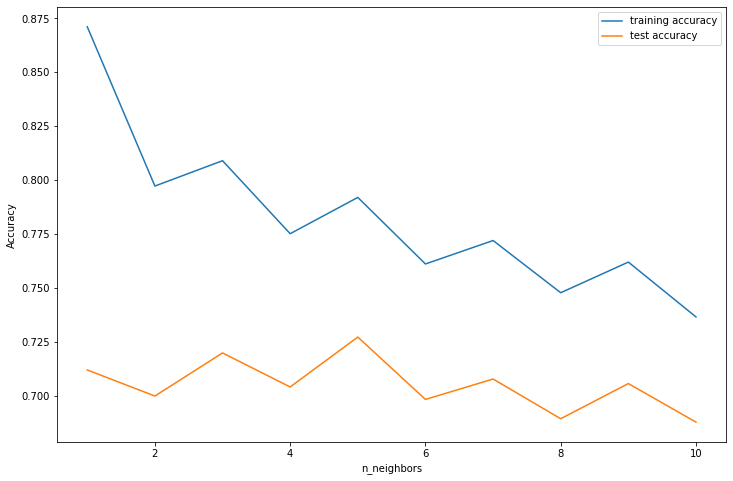

In [0]:
plt.figure(figsize=(12, 8))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

clf = KNeighborsClassifier(n_neighbors=neighbors_settings[np.argmax(test_accuracy)])
clf.fit(X_train_IDF, y_train_IDF) 
  
clf_predictions = clf.predict(X_test_IDF) 
clf_scores = cross_val_score(clf, tf_idf_model, train_df.target,cv=5)

print("The maximum accuracy of for the test set is achieved for k={}, so we would use this value".format(neighbors_settings[np.argmax(test_accuracy)]))
print("The train test split score is: ",round(test_accuracy[6],2))
print("Cross-validation scores: {}".format(clf_scores))
print("Average cross-validation score: {:.2f}".format(clf_scores.mean()))

#### KNN Confusion Matrix

In [0]:
labels = ['Non-Disaster', 'Disaster']
print_cm(confusion_matrix(y_test_IDF, clf_predictions, normalize='true'), labels)

         t\p     Non-Disaster     Disaster 
    Non-Disaster         0.92         0.08 
        Disaster         0.52         0.48 


In [0]:
print(classification_report(y_test_IDF, clf_predictions))

print('Logistic Regression Model Accuracy Score using test train split is {}'.format(round(classifier_lr.score(X_test_vct, y_test_vct),2)))
print("Cross-validation scores: {}".format(LR_scores))
print("Average cross-validation score: {:.2f}".format(LR_scores.mean()))  

              precision    recall  f1-score   support

           0       0.70      0.92      0.79      1076
           1       0.82      0.48      0.60       828

    accuracy                           0.73      1904
   macro avg       0.76      0.70      0.70      1904
weighted avg       0.75      0.73      0.71      1904

Logistic Regression Model Accuracy Score using test train split is 0.75
Cross-validation scores: [0.71218487 0.68943773 0.67577509 0.74513925]
Average cross-validation score: 0.71


### **Logistic Regression**

In [0]:
print(classification_report(y_test_vct, y_pred_lr))  

print('Logistic Regression Model Accuracy Score using test train split is {}'.format(round(classifier_lr.score(X_test_vct, y_test_vct),2)))
print("Cross-validation scores: {}".format(LR_scores))
print("Average cross-validation score: {:.2f}".format(LR_scores.mean()))

              precision    recall  f1-score   support

           0       0.72      0.88      0.80      1046
           1       0.81      0.59      0.68       858

    accuracy                           0.75      1904
   macro avg       0.76      0.73      0.74      1904
weighted avg       0.76      0.75      0.74      1904

Logistic Regression Model Accuracy Score using test train split is 0.75
Cross-validation scores: [0.71218487 0.68943773 0.67577509 0.74513925]
Average cross-validation score: 0.71


#### LR Confusion Matrix

In [0]:
labels = ['Non-Disaster', 'Disaster']
        
print_cm(confusion_matrix(y_test_vct, y_pred_lr, normalize='true'), labels)

         t\p     Non-Disaster     Disaster 
    Non-Disaster         0.88         0.12 
        Disaster         0.41         0.59 


###**Naive Bayes(Meta Features)**

####**Results for Naive Bayes using train test split:**

In [0]:
print_cm(confusion_matrix(y_test_NB, y_pred_NB, normalize='true'), labels)
print("\nThe performance of our Naive Bayes classifier for numerical class is:",np.round(y_pred_sum_num*100, 2), "%")
print("\nThe performance of our Naive Bayes classifier for categorical class is:",np.round(y_pred_sum_cat*100, 2), "%")
print("\nThe performance of our Naive Bayes classifier:",np.round(y_pred_sum_NB*100, 1), "%\n")

labels = ['Non-Disaster', 'Disaster']

         t\p     Non-Disaster     Disaster 
    Non-Disaster         0.78         0.22 
        Disaster         0.33         0.67 

The performance of our Naive Bayes classifier for numerical class is: 65.2 %

The performance of our Naive Bayes classifier for categorical class is: 71.93 %

The performance of our Naive Bayes classifier: 73.3 %



####**Results for Naive Bayes on selected features using train test split:**

In [0]:
print_cm(confusion_matrix(y_test_NB, y_pred_FS, normalize='true'), labels)
print("\nThe performance of our Naive Bayes classifier with the 5 best features is:",np.round(y_pred_sum_FS*100, 1), "%")

         t\p     Non-Disaster     Disaster 
    Non-Disaster         0.82         0.18 
        Disaster         0.35         0.65 

The performance of our Naive Bayes classifier with the 5 best features is: 74.8 %


####**Results for Naive Bayes on selected feauters using cross validation:**

In [0]:
print("\nCross-validation scores: {}".format(scores))
print("Average cross-validation score on numerical: ",round(scores.mean(),2)*100, '%')
print()
print("Cross-validation scores: {}".format(scores2))
print("Average cross-validation score on categorical: ",round(scores2.mean(),2)*100, '%')


Cross-validation scores: [0.63106796 0.6266549  0.59929391 0.63901147 0.61130742]
Average cross-validation score on numerical:  62.0 %

Cross-validation scores: [0.74051192 0.73521624 0.72021183 0.74404237 0.71908127]
Average cross-validation score on categorical:  73.0 %


####Classification report for Naive Bayes 

In [0]:
print("Classification report, all features:")
print(classification_report(y_test_NB, y_pred_NB))  

print()

print("Classification report, feature selection:")
print(classification_report(y_test_NB, y_pred_FS))  

Classification report, all features:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1091
           1       0.69      0.67      0.68       797

    accuracy                           0.73      1888
   macro avg       0.73      0.72      0.72      1888
weighted avg       0.73      0.73      0.73      1888


Classification report, feature selection:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79      1091
           1       0.72      0.65      0.69       797

    accuracy                           0.75      1888
   macro avg       0.74      0.74      0.74      1888
weighted avg       0.75      0.75      0.75      1888

